# Regresión Básica: Predecir eficiencia de gasolina

En este notebook, utilizaremos un dataset de coches [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) para construir un modelo de redes neuronales con el que  predecir el consumo de vehículos de 1970 y 1980. En este dataset dispondremos de atributos como Cilindros, desplazamiento, potencia y peso. El objetivo de este ejercicio es predecir las millas por galón de combustible (MPG).

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


Empezaremos importando las librerías principales:

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


### Leyendo los datos

En primer lugar, lo que deberemos hacer es descargar el dataset:

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\TheBridge\\.keras\\datasets\\auto-mpg.data'

Y lo leemos con pandas:

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
dataset['Model Year'].value_counts()

73    40
78    36
76    34
82    30
75    30
79    29
70    29
81    28
77    28
72    28
80    27
71    27
74    26
Name: Model Year, dtype: int64

### Limpiando los datos

Trata los missings y variables categóricas:

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [7]:
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [72]:
X

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,8,307.0,130.0,3504.0,12.0,70,1
1,8,350.0,165.0,3693.0,11.5,70,1
2,8,318.0,150.0,3436.0,11.0,70,1
3,8,304.0,150.0,3433.0,12.0,70,1
4,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6,82,1
394,4,97.0,52.0,2130.0,24.6,82,2
395,4,135.0,84.0,2295.0,11.6,82,1
396,4,120.0,79.0,2625.0,18.6,82,1


### Divide los datos en train y test

Ahora divide el dataset en train y test, donde este último sea del 80%.

Llama a los datasets ``train_dataset`` y ``test_dataset``:

In [29]:
y_col = 'MPG'
X_cols = [col for col in dataset.columns if col != y_col]

X = dataset[X_cols]
y = dataset[y_col]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Inspecciona los datos

Revisa rápidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos. Repasa los gráficos de seaborn para ver cuál nos puede ofrecer esta visión, donde la diagonal principal muestre el *kernel density estimate*:

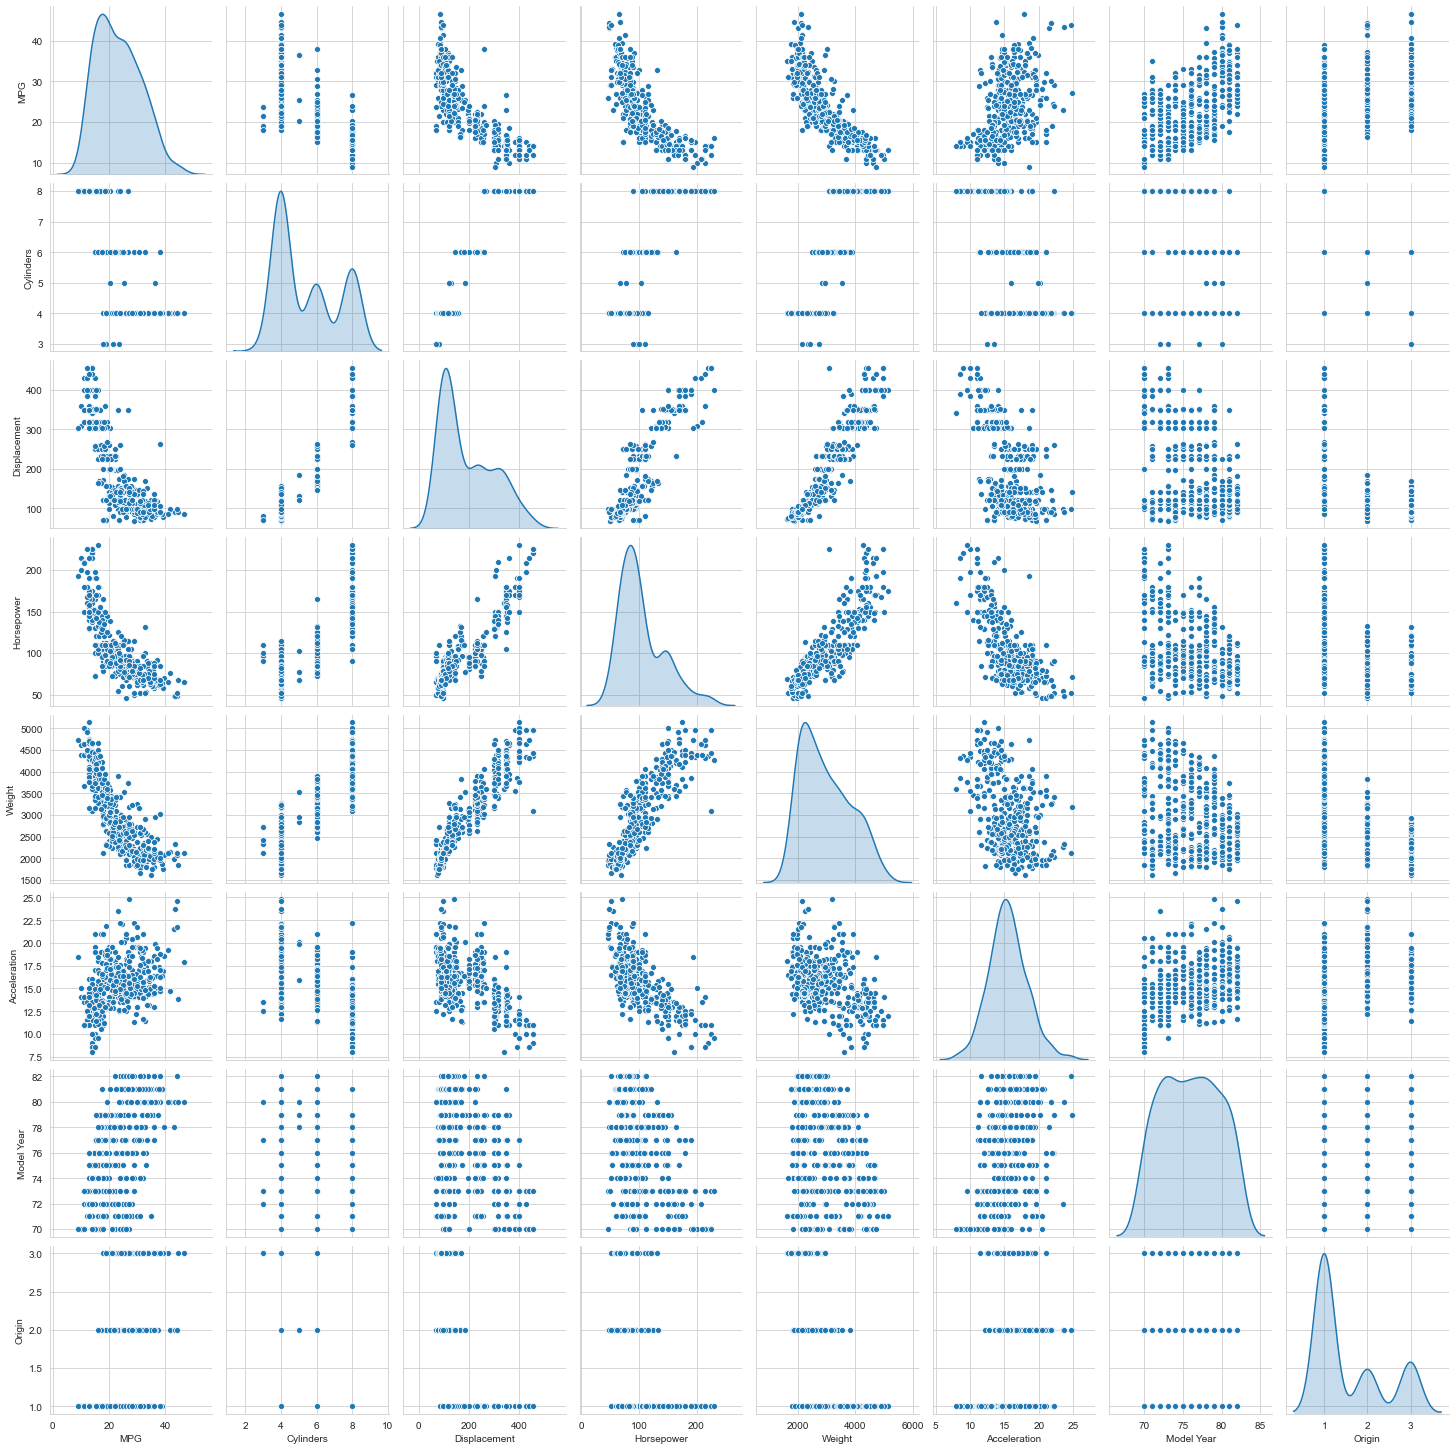

In [21]:
sns.set_style('whitegrid')
sns.pairplot(dataset, diag_kind='kde');

Muestra también los estadísticos principales del dataset:

In [22]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### Estandariza los datos

Es una buena práctica estandarizar los datasets con variables de diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada. Estandariza los datos sobreescribiendo los datos ``train_dataset`` y ``test_dataset``:

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelva un único valor continuo.

Por tanto, necesitamos construir un modelo con tres capas:
  * **Entrada**
  * **Hidden layer**: con activación relu
  * **Salida**: será de regresión, por lo que se compondrá de una única neurona.
  
Pon las neuronas que consideres para las dos primeras capas, por ejemplo, 64. Después iteraremos con diferentes combinaciones.

Para el compile utiliza un ``loss='mse'``, un ``optimizer = `tf.keras.optimizers.RMSprop(0.001)` ``, y en ``metrics`` utiliza una lista con el `mae` y `mse`.

In [41]:
X_train.shape[1:]

(7,)

In [52]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=keras.optimizers.RMSprop(0.001),
              metrics=['mae','mse'])

### Inspecciona el modelo

Utiliza uno de los métodos que hemos visto para obtener una descripción simple del modelo:

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


### Entrenar el modelo

Entrena el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

In [54]:
X_train.shape

(274, 7)

In [55]:
y_train

110    22.0
17     21.0
320    37.0
24     21.0
128    15.0
       ... 
72     15.0
107    18.0
272    23.8
352    29.9
103    11.0
Name: MPG, Length: 274, dtype: float64

In [56]:
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    validation_split=0.2)

Epoch 1/1000
7/7 [==============================] - 1s 53ms/step - loss: 609.1187 - mae: 23.3350 - mse: 609.1187 - val_loss: 666.2829 - val_mae: 24.6844 - val_mse: 666.2829
Epoch 2/1000
7/7 [==============================] - 0s 13ms/step - loss: 520.3682 - mae: 21.5201 - mse: 520.3682 - val_loss: 627.4648 - val_mae: 23.9140 - val_mse: 627.4648
Epoch 3/1000
7/7 [==============================] - 0s 12ms/step - loss: 462.3264 - mae: 20.2257 - mse: 462.3264 - val_loss: 586.2470 - val_mae: 23.0702 - val_mse: 586.2470
Epoch 4/1000
7/7 [==============================] - 0s 13ms/step - loss: 484.3698 - mae: 20.6027 - mse: 484.3698 - val_loss: 541.2998 - val_mae: 22.1150 - val_mse: 541.2998
Epoch 5/1000
7/7 [==============================] - 0s 13ms/step - loss: 439.0769 - mae: 19.4700 - mse: 439.0769 - val_loss: 489.5855 - val_mae: 20.9732 - val_mse: 489.5855
Epoch 6/1000
7/7 [==============================] - 0s 14ms/step - loss: 394.3109 - mae: 18.2706 - mse: 394.3109 - val_loss: 433.1173 -

Visualiza el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history.history`, donde representes el error de train con el de validación:

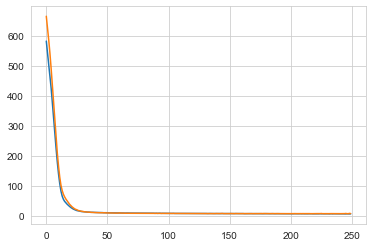

In [70]:
plt.plot(history.history['loss'][:250])
plt.plot(history.history['val_loss'][:250])

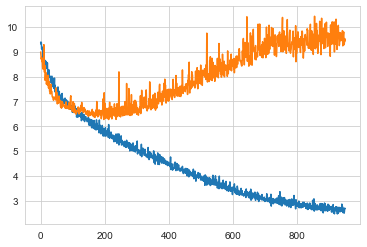

In [75]:
plt.plot(history.history['loss'][50:])
plt.plot(history.history['val_loss'][50:])

In [40]:
y_train

110    22.0
17     21.0
320    37.0
24     21.0
128    15.0
       ... 
72     15.0
107    18.0
272    23.8
352    29.9
103    11.0
Name: MPG, Length: 274, dtype: float64

¿Alguna conclusión respecto a este gráfico?

Añade un early stopping al modelo. Ya hemos visto cómo hacerlo mediante el parámetro ``callback``. En este caso, pon un ``patience`` de 10.

In [74]:
model2 = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model2.compile(loss='mse',
              optimizer=keras.optimizers.RMSprop(0.001),
              metrics=['mae','mse'])


early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history2 = model2.fit(X_train,
                      y_train,
                      epochs=1000,
                      validation_split=0.2,
                      callbacks=[early_stopping])

Epoch 1/1000
7/7 [==============================] - 1s 59ms/step - loss: 556.9330 - mae: 22.3072 - mse: 556.9330 - val_loss: 632.2485 - val_mae: 24.0346 - val_mse: 632.2485
Epoch 2/1000
7/7 [==============================] - 0s 15ms/step - loss: 516.9807 - mae: 21.3977 - mse: 516.9807 - val_loss: 578.5500 - val_mae: 22.9425 - val_mse: 578.5500
Epoch 3/1000
7/7 [==============================] - 0s 15ms/step - loss: 457.5730 - mae: 20.0167 - mse: 457.5730 - val_loss: 520.6888 - val_mae: 21.7049 - val_mse: 520.6888
Epoch 4/1000
7/7 [==============================] - 0s 14ms/step - loss: 399.8027 - mae: 18.5493 - mse: 399.8027 - val_loss: 460.1300 - val_mae: 20.3271 - val_mse: 460.1300
Epoch 5/1000
7/7 [==============================] - 0s 13ms/step - loss: 368.6316 - mae: 17.7378 - mse: 368.6316 - val_loss: 398.5083 - val_mae: 18.8106 - val_mse: 398.5083
Epoch 6/1000
7/7 [==============================] - 0s 14ms/step - loss: 305.9459 - mae: 15.8983 - mse: 305.9459 - val_loss: 335.0360 -

Evalúa el rendimiento del modelo mediante el estudio de los 3 valores que te devuelve el método que hemos visto para ello, que son: ``loss``, ``mae`` y ``mse``:

In [82]:
v_loss, v_mae, v_mse = model2.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 6.2685 - mae: 1.8416 - mse: 6.2685


In [81]:
v_loss1, v_mae1, v_mse1 = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 7.6414 - mae: 2.1119 - mse: 7.6414


In [84]:
print(f"Modelo 1: {v_mse1}, Modelo2: {v_mse}")

Modelo 1: 7.641446590423584, Modelo2: 6.2685370445251465


### Prediciendo

Ahora, probemos el modelo realizando una predicción de los primeros 10 valores y represéntalos en una gráfica frente a sus valores reales, es decir, uno en cada eje:

In [100]:
X_test[:2]

array([[-0.87326597, -0.97045773, -0.94268785, -0.9522834 ,  0.86858   ,
        -1.14549896,  0.53818694],
       [-0.87326597, -0.72963628,  0.26577814, -0.22865418,  0.06230645,
         0.51517149,  0.53818694]])

In [98]:
X_train

array([[-0.87326597, -0.85486343, -0.28591285, ...,  0.34274942,
        -0.86872055,  1.76704713],
       [ 0.29392855,  0.03135952, -0.52235185, ...,  0.16747256,
        -1.69905578, -0.69067324],
       [-0.87326597, -0.74890199, -0.33845485, ..., -0.18308116,
         1.06872831,  1.76704713],
       ...,
       [-0.87326597, -0.44065053, -0.52235185, ...,  0.72835851,
         0.51517149, -0.69067324],
       [-0.87326597, -0.95119201, -1.04777185, ...,  1.81507503,
         1.34550671, -0.69067324],
       [ 1.46112306,  1.95793117,  1.18526314, ..., -0.53363487,
        -0.86872055, -0.69067324]])

In [86]:
X_new = X_test[:10]
y_pred = model.predict(X_new)
y_pred2 = model2.predict(X_new)

plt.plot(y_test[:10].values, label='test')
plt.plot(y_pred, label='pred_sin_es')
plt.plot(y_pred2, label='pred_con_es')
plt.legend()

array([[25.844038],
       [21.827442],
       [34.788364],
       [23.602867],
       [24.828539],
       [29.256886],
       [13.289204],
       [30.013433],
       [21.398375],
       [34.00485 ]], dtype=float32)

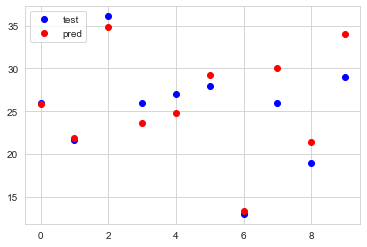

In [95]:
plt.plot(y_test[:10].values, 'bo', label='test')
plt.plot(y_pred, 'ro', label='pred')
plt.legend()

In [88]:
X_new = X_test[:10]
y_pred2 = model2.predict(X_new)
y_pred2

array([[25.542004],
       [20.483576],
       [35.458363],
       [26.407093],
       [28.16041 ],
       [29.241825],
       [13.429279],
       [30.134245],
       [19.388424],
       [31.548212]], dtype=float32)

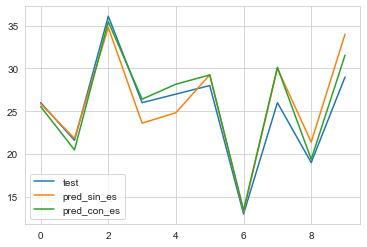

In [97]:
plt.plot(y_test[:10].values, label='test')
plt.plot(y_pred, label='pred_sin_es')
plt.plot(y_pred2, label='pred_con_es')
plt.legend()

### EXTRA: Mejora el modelo

Aunque estemos ante muy pocas muestras, y el verdadero poder de las redes neuronales se observa con grandes volúmenes de datos, vamos a tratar de mejorar los resultados.

Modifica algunos de los parámetros utilizados en este modelo para intentar mejorar los resultados. Hay muchas posibilidades, pero empieza tocando un parámtro hasta encontrar un valor adecuado y luego modiica otros hasta obtener algo que sea suficientemente bueno.

También podrías crear nuevas variables para ver si mejora el modelo.